<a href="https://colab.research.google.com/github/sabumjung/DL-test/blob/master/Lecture28_Predicting_molecular_properties_using_graph_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다양한 Graph Neural Network을 이용해서 분자의 성질을 예측해보자. 
----
이번 시간에는 pytorch_geometric의 다양한 Graph Neural Network layer를 이용해서 분자 물성 예측을 수행해본다.

이번 시간에는 더 많은 atom feature와 edge feature를 고려하여 GNN 학습을 수행해본다. 

# New Section

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 10 12:38:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.5 MB 5.9 MB/s 


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

import condacolab
condacolab.check()

!mamba install -c conda-forge rdkit

Streaming output truncated to the last 5000 lines.
xorg-libx11              [] (00m:03s) Waiting...
xorg-libxrender          [] (00m:03s) Waiting...
zipp                     [] (00m:03s) Waiting...
icu                      [] (00m:03s) Waiting...
libnghttp2               [] (00m:03s) Waiting...
tk                       [] (00m:03s) Waiting...
cycler                   [] (00m:03s) Waiting...
fonts-conda-forge        [] (00m:03s) Waiting...
importlib-metadata       [] (00m:03s) Waiting...
lerc                     [] (00m:03s) Waiting...
libgfortran5             [] (00m:02s) Waiting...
libuuid                  [] (00m:02s) Waiting...
openjpeg                 [] (00m:02s) Waiting...
pyparsing                [] (00m:02s) Waiting...
typing-extensions        [] (00m:02s) Waiting...
xorg-libxext             [] (00m:02s) Waiting...
brotli                   [] (00m:02s) Waiting...
giflib                   [] (00m:02s) Waiting...
cryptography             [] (00m:02s) Waiting...
libbrotlienc      

In [ ]:
import rdkit
import rdkit.Chem as Chem
import numpy as np
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric
from torch_geometric.data import Data

In [ ]:
import pandas as pd
import joblib

Pandas를 이용해서 데이터를 불러온다. 


참고 사이트: https://wikidocs.net/book/3488

In [ ]:
#pubchem = pd.read_csv("PubchemQC_HOMO-LUMO_100000.csv")
pubchem = pd.read_csv("https://www.dropbox.com/s/stxhvcgk0kvs89m/PubchemQC_HOMO-LUMO_100000.csv?dl=1")

In [ ]:
pubchem

,#Index,HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES
0,1,4.015,0.002,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
1,2,5.758,0.000,CC(=O)OC(CC(=O)O)C[N+](C)(C)C
2,3,4.039,0.053,C1=CC(C(C(=C1)C(=O)O)O)O
3,4,5.596,0.004,CC(CN)O
4,5,4.278,0.001,C(C(=O)COP(=O)(O)O)N
...,...,...,...,...
99994,303049,4.282,0.092,COC(C1=CC=CC2=CC=CC=C21)C(=O)O
99995,303051,5.805,0.005,CCS(=O)(=O)N1CCCCC1C
99996,303052,5.891,0.019,CCN(CC)S(=O)(=O)CC
99997,303053,5.876,0.006,CCCN(CCC)S(=O)(=O)CC


## 분자를 그래프로 나타내기

----
이번 예측에서는 H, B, C, N, O, F, P, S, Cl 만으로 이루어진 분자들만 고려하도록 하겠습니다.

이를 위해서 간단히 분자가 H, B, C, N, O, F, P, S, Cl만으로 구성되어 있는지를 확인하는 함수를 정의하겠습니다. 

In [ ]:
def check_atoms(mol):
  """
  This function checks whether all atoms are valid
  """
  valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl')
  flag = True
  for atm in mol.GetAtoms(): # 분자 안에 존재하는 모든 atom에 대해서 loop을 수행. 
    if atm.GetSymbol() not in valid_atoms:
      flag = False
      break
  return flag

In [ ]:
from tqdm import tqdm
homo_lumo_data = []
for smi, score in tqdm(zip(pubchem["SMILES"], pubchem["HOMO-LUMO_gap(eV)"])):
  mol = Chem.MolFromSmiles(smi)
  if check_atoms(mol): # 모든 atom들이 원하는 atom들로만 구성되어 있을 때.
    homo_lumo_data.append((mol, score)) 
  else:
    continue

99999it [01:10, 1420.31it/s]


### Hybridization types in RDKit
----
https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.HybridizationType

In [ ]:
def convert_mol_to_graph(mol, use_pos = False):
    
    mol2 = Chem.AddHs(mol) # 수소 붙임.        
    n_bonds = len(mol2.GetBonds()) # 분자의 공유 결합 개수 
    n_atoms = len(mol2.GetAtoms()) # 분자의 원자 개수
    
    edge_index = []
    edge_attr = []
    edge_weight = []
    for edge_idx in range(n_bonds): # 전체 공유 결합에 대해서 loop을 돌린다. 
        bond = mol2.GetBondWithIdx(edge_idx) # 각 공유 결합에 대해서 시작 atom과 끝 atom의 인덱스를 확인. 
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]) # undirected graph를 만들기 위해서 순서를 바꿔서 edge를 2번 넣어준다. 
        
        # BondType (4-dimensional one-hot)
        btype = bond.GetBondType() # 공유 결합의 종류.
        if btype == Chem.rdchem.BondType.SINGLE:
            bond_one_hot = [1, 0, 0, 0]
            edge_weight.extend([1.0, 1.0])
        elif btype == Chem.rdchem.BondType.AROMATIC:
            bond_one_hot = [0, 1, 0, 0]
            edge_weight.extend([1.5, 1.5])
        elif btype == Chem.rdchem.BondType.DOUBLE:
            bond_one_hot = [0, 0, 1, 0]
            edge_weight.extend([2.0, 2.0])
        elif btype == Chem.rdchem.BondType.TRIPLE:
            bond_one_hot = [0, 0, 0, 1]   
            edge_weight.extend([3.0, 3.0])  
        
        # BondStereo (6-dimensional one-hot)
        stype = bond.GetStereo()
        if stype == Chem.rdchem.BondStereo.STEREOANY:
          stereo_one_hot = [1, 0, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOCIS:
          stereo_one_hot = [0, 1, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOE:
          stereo_one_hot = [0, 0, 1, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREONONE:
          stereo_one_hot = [0, 0, 0, 1, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
          stereo_one_hot = [0, 0, 0, 0, 1, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOZ:
          stereo_one_hot = [0, 0, 0, 0, 0, 1]
        
        # Is this bond included in a ring?
        if bond.IsInRing():
          ring_bond = 1
        else:
          ring_bond = 0

        # Is this bond a conjugated bond?
        if bond.GetIsConjugated():
          conjugate = 1
        else:
          conjugate = 0
        
        # In total 12-dimensional edge attribute 
        # bond-type (4-dim), bondstereo (6-dim), (ring, conjugate)
        # Can you image more?
        attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate] # 12 차원의 공유 결합 속성. 

        # 분자는 undirected graph이므로 edge가 두 번 정의된다. 
        # 그러므로 동일한 attribute를 두 번 넣어주어야 한다.
        edge_attr.append(attr)
        edge_attr.append(attr)
    ## edge 속성 계산 완료

    ## node 속성 계산    
    # RDKit으로 계산할 수 있는 Atom의 속성은 아래 링크에서 확인할 수 있다.
    # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
    # 
    #.        0.   1.   2.   3.   4.   5.   6.   7.   8.
    #        'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'
    valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8}
    node_attr = []
    for atm_id in range(n_atoms):
        # Select an atom.
        atm = mol2.GetAtomWithIdx(atm_id)

        # Atom symbol check (9-dim)
        sym = atm.GetSymbol()
        atm_one_hot = [0] * len(valid_atoms) # 0이 9개 들어있는 리스트를 만든다. 
        idx = valid_atoms[sym] # sym에 해당하는 원소 기호가 몇 번째에 있는지?
        atm_one_hot[idx] = 1   # 해당되는 원소의 위치만 1로 바꾼다. 
        
        # Check hybridization (7-dim)
        hybrid = atm.GetHybridization()
        hybrid_one_hot = [0] * 7 # [0, 0, 0, 0, 0, 0, 0]
        if hybrid == Chem.HybridizationType.SP3:
          hybrid_one_hot[0] = 1
        elif hybrid == Chem.HybridizationType.SP2:
          hybrid_one_hot[1] = 1
        elif hybrid == Chem.HybridizationType.SP:
          hybrid_one_hot[2] = 1
        elif hybrid == Chem.HybridizationType.S:
          hybrid_one_hot[3] = 1
        elif hybrid == Chem.HybridizationType.SP3D:
          hybrid_one_hot[4] = 1
        elif hybrid == Chem.HybridizationType.SP3D2:
          hybrid_one_hot[5] = 1
        else: # hybridization이 제대로 정의되지 않은 나머지의 모든 경우.
          hybrid_one_hot[6] = 1

        # aromatic 인지 아닌지?  (True/False)
        if atm.GetIsAromatic():
          arom = 1
        else:
          arom = 0

        # ring 안에 존재하는지 아닌지? (True/False)
        if atm.IsInRing():
          ring_flag = 1
        else:
          ring_flag = 0 
        
        # Degree (공유 결합의 개수)  (6-dim, one-hot)
        # 0, 1, 2, 3, 4, >=5    
        degree_one_hot = [0, 0, 0, 0, 0, 0]
        degree = atm.GetTotalDegree()
        if degree >= 5: # 5개 이상의 공유 결합을 가지는 원자.
          degree_one_hot[5]=1
        else:
          degree_one_hot[degree]=1

        # Number of hydrogens (5-dim, one-hot)
        # 결합되어 있는 수소의 개수. 
        # 0, 1, 2, 3, >=4
        num_h = atm.GetTotalNumHs()
        hydrogen_one_hot = [0, 0, 0, 0, 0]
        if num_h >= 4:
          hydrogen_one_hot[4] = 1
        else:
          hydrogen_one_hot[num_h] = 1

        # Chirality (4-dim, one-hot)
        chiral = atm.GetChiralTag()
        if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
          chiral_one_hot = [1, 0, 0, 0]
        # Counter-clock-wise (반시계)
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
          chiral_one_hot = [0, 1, 0, 0]
        # Clockwise (시계방향)
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
          chiral_one_hot = [0, 0, 1, 0]
        # Chirality 정의되지 않음.
        elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
          chiral_one_hot = [0, 0, 0, 1]

        # 원자 특성 계산 [원자 symbol one-hot, 공유 결합 개수, 전체 valence의 개수 (explicit + implicit), is an atom aromatic (True/False)? ]
        # 더 추가 가능!
        # in total 25-dim.
        # 9-dim, 7-dim, 6-dim, 5-dim, 4-dim, 4-dim = 35-dim
        attr = atm_one_hot + hybrid_one_hot + \
                degree_one_hot + hydrogen_one_hot + \
                chiral_one_hot + \
                [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

        #print(atm_id, attr)
        node_attr.append(attr)
    
    ## node 속성 계산 완료

    # PyTorch Tensor로 변환. 
    edge_attr = torch.tensor(edge_attr, dtype = torch.float)
    node_attr = torch.tensor(node_attr, dtype = torch.float)
    edge_index = torch.tensor(edge_index, dtype = torch.long)
    edge_index = edge_index.t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype = torch.float)
    
    if use_pos: # 만일 3D 좌표 정보를 사용한다면
        val = AllChem.EmbedMolecule(mol2)
        if val !=0:
          print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
          return None   
         
        pos_list = [] # this is optional
        for atm_id in range(n_atoms):
          # Get Atomic Position. 
          atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
          crd = [atm_pos.x, atm_pos.y, atm_pos.z]
          pos_list.append(crd)
        
        pos = torch.tensor(pos_list, dtype=torch.float)
    else:
      pos = None
    #print(edge_attr.shape)
    #print(node_attr.shape)
    #print(edge_index.shape)

    return edge_index, node_attr, edge_attr, pos, edge_weight

In [ ]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(homo_lumo_data[0][0])

In [ ]:
d0 = Data(x = x, edge_index = edge_index, edge_attr = edge_attr, pos = pos, edge_weight = edge_weight)

In [ ]:
print(d0)

Data(x=[31, 35], edge_index=[2, 60], edge_attr=[60, 12], edge_weight=[60])


In [ ]:
d0.num_nodes

31

## 이제 분자들을 하나씩 PyG의 Data type으로 변환해봅시다.
----

In [ ]:
data_list = []
for mol, score in tqdm(homo_lumo_data):
    result = convert_mol_to_graph(mol)
    if result is None:
        continue
        
    edge_index, node_attr, edge_attr, pos, edge_weight = result
    y = torch.tensor([[score]], dtype = torch.float)
    dtmp = Data(x = node_attr, pos = pos, edge_index = edge_index, edge_attr = edge_attr, edge_weight = edge_weight, y = y)
    data_list.append(dtmp)

100%|██████████| 99999/99999 [01:09<00:00, 1429.53it/s]


In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
import random
random.seed(12345)
random.shuffle(data_list)

In [ ]:
train_set, val_set, test_set = data_list[:-20000], data_list[-20000:-15000], data_list[-15000:] 
print(f"Number of training set: {len(train_set)}")
print(f"Number of Validaation set: {len(val_set)}")
print(f"Number of test set: {len(test_set)}")

Number of training set: 79999
Number of Validaation set: 5000
Number of test set: 15000


In [ ]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, drop_last = False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, drop_last = False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, drop_last = False)

In [ ]:
print(train_loader)

In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))

79999
15000
5000


In [ ]:
for batch in train_loader:
    print(batch)
    print(batch.batch)
    print(batch.num_graphs)
    print(batch.num_node_features)
    break

DataBatch(x=[2906, 35], edge_index=[2, 5902], edge_attr=[5902, 12], y=[100, 1], edge_weight=[5902], batch=[2906], ptr=[101])
tensor([ 0,  0,  0,  ..., 99, 99, 99])
100
35


In [ ]:
data = data_list[0]
print(data.keys)

['y', 'x', 'edge_index', 'edge_weight', 'edge_attr']


In [ ]:
data.num_node_features

35

## 실제로 Graph Convolutional Network을 정의해봅시다. 

----

Convolution 3층과 마지막 1차원의 출력을 내어놓는 네트워크 입니다. 


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class myGCN(torch.nn.Module):
    def __init__(self, in_channel=35, hidden_layer_size=70):
        super().__init__()
        self.conv1 = GCNConv(in_channel, hidden_layer_size) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
        #self.conv4 = GCNConv(hidden_layer_size, hidden_layer_size)
        #self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.gelu(x)

        x = self.conv3(x, edge_index)
        x = F.gelu(x)

        #x = self.conv4(x, edge_index)
        #x = F.elu(x)
        
        #x = self.conv5(x, edge_index)
        #x = F.elu(x)

        # READOUT 
        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = self.lin1(x) # 70 dim -> 35-dim
        x = F.elu(x)
        x = self.lin2(x) # 35 dim -> 1-dim

        return x

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)
model = GCN(in_channel = 35, hidden_layer_size = 70)
model.to(device)

cpu


GCN(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
print(model)

GCN(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)


In [ ]:
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    conv1.bias    |     70     |
| conv1.lin.weight |    2450    |
|    conv2.bias    |     70     |
| conv2.lin.weight |    4900    |
|    conv3.bias    |     70     |
| conv3.lin.weight |    4900    |
|   lin1.weight    |    2450    |
|    lin1.bias     |     35     |
|   lin2.weight    |     35     |
|    lin2.bias     |     1      |
+------------------+------------+
Total Trainable Params: 14981


14981

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
import sys

In [ ]:
def test(loader):
    model.eval()
    error = 0.0
    out_all = []
    true = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        tmp = (out - data.y)**2
        error += tmp.sum().item()  # Check against ground-truth labels.
        
        out_all.extend([x.item() for x in out])
        true.extend([x.item() for x in data.y])
        
    return error / len(loader.dataset), out_all, true  # Derive ratio of correct predictions.

In [ ]:
def train():
    model.train()
    for idx, batch in enumerate(train_loader):
        out = model(batch.to(device))
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        if idx%100 == 0:
            print(f"IDX: {idx:5d}\tLoss: {loss:.4f}")

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    
    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)
    
    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 21.9653
IDX:   100	Loss: 0.7779
IDX:   200	Loss: 0.6936
IDX:   300	Loss: 0.5428
IDX:   400	Loss: 0.6732
IDX:   500	Loss: 0.3282
IDX:   600	Loss: 0.5631
IDX:   700	Loss: 0.3447
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.4775, Val Acc: 0.4830, Test Acc: 0.4847
Epoch:  2
IDX:     0	Loss: 0.5361
IDX:   100	Loss: 0.6811
IDX:   200	Loss: 0.3576
IDX:   300	Loss: 0.4542
IDX:   400	Loss: 0.3359
IDX:   500	Loss: 0.4820
IDX:   600	Loss: 0.3863
IDX:   700	Loss: 0.3929
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.2882, Val Acc: 0.2949, Test Acc: 0.3049
Epoch:  3
IDX:     0	Loss: 0.2583
IDX:   100	Loss: 0.2308
IDX:   200	Loss: 0.2435
IDX:   300	Loss: 0.2335
IDX:   400	Loss: 0.2527
IDX:   500	Loss: 0.2036
IDX:   600	Loss: 0.2547
IDX:   700	Loss: 0.2472
-------------------------------------------------------------

## Loss 값의 변화를 plot 해보자. 
----


In [ ]:
import matplotlib.pyplot as plt
def draw_loss_change(train_loss, val_loss, test_loss):
  plt.figure(figsize=(8,8)) # 빈 그림을 정의
  plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
  plt.plot(test_loss, color = 'g',  label = 'Test loss') # test set loss
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best') # label을 표시 하겠다. 

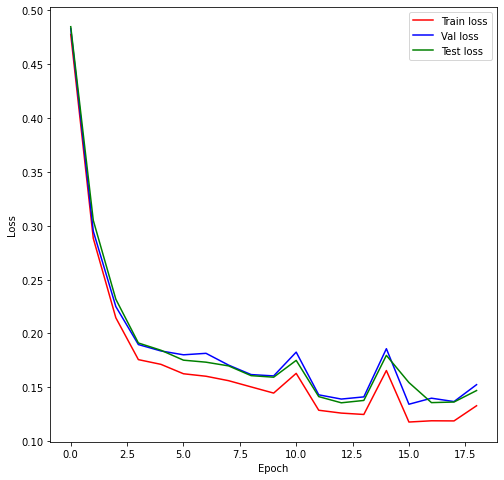

In [ ]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

(-0.5, 12.0)

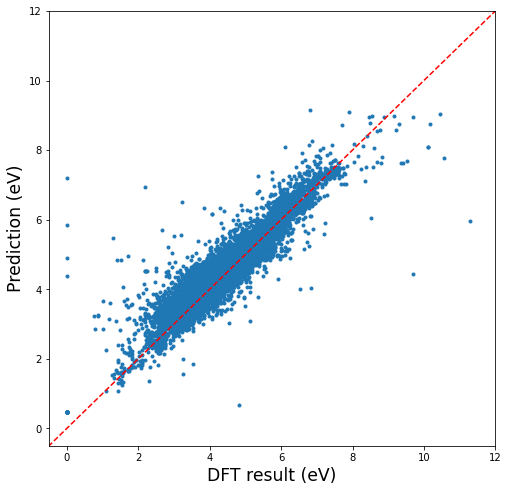

In [ ]:
import matplotlib.pyplot as plt
#out_all = [x.detach().numpy() for x in out_all]
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(experimental, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

In [ ]:
print(true_all)

[4.888999938964844, 3.125, 4.783999919891357, 3.450000047683716, 4.447000026702881, 4.242000102996826, 4.946000099182129, 4.033999919891357, 5.084000110626221, 3.7699999809265137, 3.3989999294281006, 5.486000061035156, 3.4579999446868896, 4.311999797821045, 5.190999984741211, 3.555999994277954, 5.195000171661377, 4.796999931335449, 5.543000221252441, 4.956999778747559, 5.314000129699707, 5.697999954223633, 4.781000137329102, 5.605000019073486, 4.948999881744385, 4.040999889373779, 3.375999927520752, 5.129000186920166, 4.317999839782715, 3.421999931335449, 5.289999961853027, 2.7790000438690186, 5.210000038146973, 4.586999893188477, 3.8959999084472656, 5.4029998779296875, 4.497000217437744, 4.882999897003174, 4.699999809265137, 4.673999786376953, 4.335000038146973, 4.6519999504089355, 5.565999984741211, 3.1570000648498535, 3.5160000324249268, 4.256999969482422, 6.239999771118164, 4.210000038146973, 5.004000186920166, 5.294000148773193, 3.5179998874664307, 6.276000022888184, 5.85699987411

In [ ]:
corr = np.corrcoef(experimental, prediction)
print(corr)

[[1.         0.93232051]
 [0.93232051 1.        ]]


In [ ]:
print(f"Pearson R: {corr[0,1]:.4f}")

Pearson R: 0.9323


# GCN layer에 edge weight 정보를 넣으면 더 좋아질까? 
-----

* Single bond 는 가중치 1
* Doulbe bond 는 가중치 2
* Triple bond 는 가중치 3
* Aromatic은 가중치 1.5

이런식으로 edge_weight를 정의하였음. 


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class mymodel2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_feat = 35
        self.conv1 = GCNConv(n_feat, n_feat*2) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GCNConv(n_feat*2, n_feat*2)
        self.conv3 = GCNConv(n_feat*2, n_feat*2)
        #self.conv4 = GCNConv(n_feat*2, n_feat*2)
        #self.conv5 = GCNConv(n_feat*2, n_feat*2)
        self.lin1 = Linear(n_feat*2, n_feat)
        self.lin2 = Linear(n_feat, 1)
        
    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index, edge_weight) # 이번에는 edge_weight를 고려해서 학습한다, edge_weight는 optional한 정보. 
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.gelu(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.gelu(x)
        #x = self.conv4(x, edge_index, edge_weight)
        #x = F.elu(x)
        #x = self.conv5(x, edge_index, edge_weight)
        #x = F.elu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.elu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
 if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)
model = mymodel2()
model.to(device)

cpu


mymodel2(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train()
    train_acc, out_tmp, true_tmp = test(train_loader)
    test_acc, out_all, true_all = test(test_loader)
    val_acc, val_pred, val_true = test(val_loader)
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 19.0008
IDX:   100	Loss: 0.9004
IDX:   200	Loss: 0.5355
IDX:   300	Loss: 0.5160
IDX:   400	Loss: 0.4676
IDX:   500	Loss: 0.5118
IDX:   600	Loss: 0.4160
IDX:   700	Loss: 0.3750
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.4906, Val Acc: 0.5041, Test Acc: 0.4991
Epoch:  2
IDX:     0	Loss: 0.2841
IDX:   100	Loss: 0.3624
IDX:   200	Loss: 0.4550
IDX:   300	Loss: 0.4071
IDX:   400	Loss: 0.3245
IDX:   500	Loss: 0.4076
IDX:   600	Loss: 0.3025
IDX:   700	Loss: 0.3577
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.3025, Val Acc: 0.3231, Test Acc: 0.3205
Epoch:  3
IDX:     0	Loss: 0.2220
IDX:   100	Loss: 0.2919
IDX:   200	Loss: 0.3199
IDX:   300	Loss: 0.1752
IDX:   400	Loss: 0.2577
IDX:   500	Loss: 0.2456
IDX:   600	Loss: 0.2613
IDX:   700	Loss: 0.2302
-------------------------------------------------------------

## 결론: edge_weight를 고려하면 아주 미세하게 더 좋은 결과를 보인다. 
----
edge_weight가 분자의 공유 결합을 표현할 때 적절한가? 



(-0.5, 12.0)

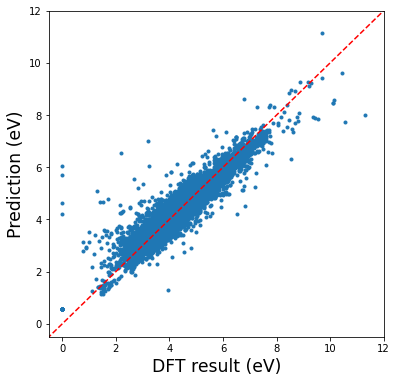

In [ ]:
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

In [ ]:
corr = np.corrcoef(experimental, prediction)
r = corr[0,1]
print(f"Pearson R: {r:.4f}")

Pearson R: 0.9319


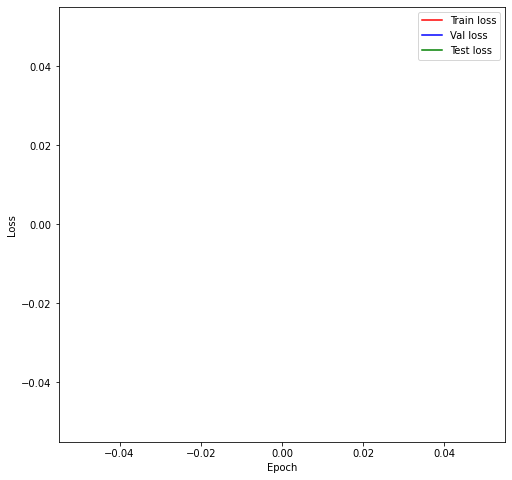

In [ ]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

# Graph Attentive Network
----
GCNConv 말고 다른 graph convolution layer인 Graph Attentive Network의 성능을 알아봅시다. 


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

class my_GAT_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(35, 70) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GATConv(70, 70)
        self.conv3 = GATConv(70, 70)
        #self.conv4 = GATConv(70, 70)
        #self.conv5 = GATConv(70, 70)

        self.lin1 = Linear(70, 35)
        self.lin2 = Linear(35, 1)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index) # node_attribute와 edge_index만 사용하고 있음. -> edge의 attribute는 사용하고 있지 않음. 
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.gelu(x)
        x = self.conv3(x, edge_index)
        x = F.gelu(x)
        #x = self.conv4(x, edge_index)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = my_GAT_model()
model.to(device)

my_GAT_model(
  (conv1): GATConv(35, 70, heads=1)
  (conv2): GATConv(70, 70, heads=1)
  (conv3): GATConv(70, 70, heads=1)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
count_parameters(model)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|    conv1.att_src     |     70     |
|    conv1.att_dst     |     70     |
|      conv1.bias      |     70     |
| conv1.lin_src.weight |    2450    |
|    conv2.att_src     |     70     |
|    conv2.att_dst     |     70     |
|      conv2.bias      |     70     |
| conv2.lin_src.weight |    4900    |
|    conv3.att_src     |     70     |
|    conv3.att_dst     |     70     |
|      conv3.bias      |     70     |
| conv3.lin_src.weight |    4900    |
|     lin1.weight      |    2450    |
|      lin1.bias       |     35     |
|     lin2.weight      |     35     |
|      lin2.bias       |     1      |
+----------------------+------------+
Total Trainable Params: 15401


15401

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
train_acc_list = []
test_acc_list = []
val_acc_list = []
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train()
    
    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)
    
    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 3.8142
IDX:   100	Loss: 0.6316
IDX:   200	Loss: 0.4998
IDX:   300	Loss: 0.4921
IDX:   400	Loss: 0.4979
IDX:   500	Loss: 0.5156
IDX:   600	Loss: 0.5005
IDX:   700	Loss: 0.4009
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.4084, Val Acc: 0.4197, Test Acc: 0.4140
Epoch:  2
IDX:     0	Loss: 0.3543
IDX:   100	Loss: 0.4619
IDX:   200	Loss: 0.3329
IDX:   300	Loss: 0.2714
IDX:   400	Loss: 0.2994
IDX:   500	Loss: 0.3355
IDX:   600	Loss: 0.3117
IDX:   700	Loss: 0.2625
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.2620, Val Acc: 0.2873, Test Acc: 0.2706
Epoch:  3
IDX:     0	Loss: 0.1986
IDX:   100	Loss: 0.3242
IDX:   200	Loss: 0.2533
IDX:   300	Loss: 0.3245
IDX:   400	Loss: 0.3975
IDX:   500	Loss: 0.3682
IDX:   600	Loss: 0.4188
IDX:   700	Loss: 0.3240
--------------------------------------------------------------

(-0.5, 12.0)

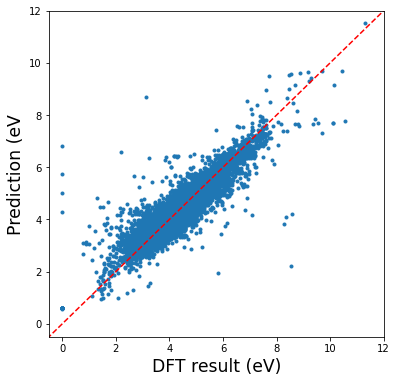

In [ ]:
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

In [ ]:
np.corrcoef(experimental, prediction)

array([[1.        , 0.91812107],
       [0.91812107, 1.        ]])

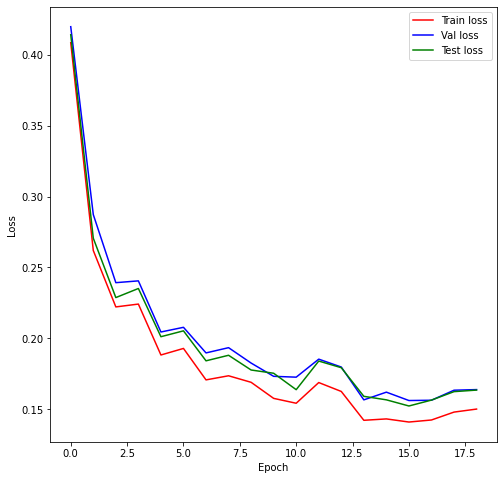

In [ ]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

# 어떤 layer가 어떤 정보를 사용하는가? 
----
## GNN Cheatsheet

https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html#

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv
from torch_geometric.nn import global_mean_pool

class myGATv2Conv_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATv2Conv(35, 70, edge_dim=12) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GATv2Conv(70, 70, edge_dim=12)
        self.conv3 = GATv2Conv(70, 70, edge_dim=12)
        #self.conv4 = GATv2Conv(70, 70, edge_dim=12)
        #self.conv5 = GATv2Conv(70, 70, edge_dim=12)

        self.lin1 = Linear(70, 35)
        self.lin2 = Linear(35, 1)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)
        #x = self.conv4(x, edge_index, edge_attr)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index, edge_attr)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = myGATv2Conv_model()
model.to(device)

myGATv2Conv_model(
  (conv1): GATv2Conv(35, 70, heads=1)
  (conv2): GATv2Conv(70, 70, heads=1)
  (conv3): GATv2Conv(70, 70, heads=1)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|       conv1.att       |     70     |
|       conv1.bias      |     70     |
|   conv1.lin_l.weight  |    2450    |
|    conv1.lin_l.bias   |     70     |
|   conv1.lin_r.weight  |    2450    |
|    conv1.lin_r.bias   |     70     |
| conv1.lin_edge.weight |    840     |
|       conv2.att       |     70     |
|       conv2.bias      |     70     |
|   conv2.lin_l.weight  |    4900    |
|    conv2.lin_l.bias   |     70     |
|   conv2.lin_r.weight  |    4900    |
|    conv2.lin_r.bias   |     70     |
| conv2.lin_edge.weight |    840     |
|       conv3.att       |     70     |
|       conv3.bias      |     70     |
|   conv3.lin_l.weight  |    4900    |
|    conv3.lin_l.bias   |     70     |
|   conv3.lin_r.weight  |    4900    |
|    conv3.lin_r.bias   |     70     |
| conv3.lin_edge.weight |    840     |
|      lin1.weight      |    2450    |
|       lin1.bias       |

30381

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
train_acc_list = []
test_acc_list = []
val_acc_list = []
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    
    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)
    
    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 21.1362
IDX:   100	Loss: 0.8327
IDX:   200	Loss: 0.5801
IDX:   300	Loss: 0.4980
IDX:   400	Loss: 0.4874
IDX:   500	Loss: 0.7364
IDX:   600	Loss: 0.4486
IDX:   700	Loss: 0.3284
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.3069, Val Acc: 0.3148, Test Acc: 0.3148
Epoch:  2
IDX:     0	Loss: 0.2759
IDX:   100	Loss: 0.3796
IDX:   200	Loss: 0.2650
IDX:   300	Loss: 0.2438
IDX:   400	Loss: 0.4471
IDX:   500	Loss: 0.2078
IDX:   600	Loss: 0.1841
IDX:   700	Loss: 0.4089
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.3045, Val Acc: 0.3236, Test Acc: 0.3153
Epoch:  3
IDX:     0	Loss: 0.2567
IDX:   100	Loss: 0.2880
IDX:   200	Loss: 0.1752
IDX:   300	Loss: 0.2085
IDX:   400	Loss: 0.3345
IDX:   500	Loss: 0.2347
IDX:   600	Loss: 0.3115
IDX:   700	Loss: 0.1899
-------------------------------------------------------------

# (Exercise) Build you own network using other layer, GraphConv layer

또 다른 모델인 GraphConv layer를 이용해서 모델을 만들어 보라~

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv, GraphConv
from torch_geometric.nn import global_mean_pool

class my_GraphConv_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphConv(...) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GraphConv(...)
        self.conv3 = GraphConv(...)
        self.conv4 = GraphConv(...)
        self.conv5 = GraphConv(...)

        self.lin1 = Linear(...)
        self.lin2 = Linear(...)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)
        #x = self.conv4(x, edge_index, edge_attr)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index, edge_attr)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = my_GraphConv_model()
print(model)
count_parameters(model)

GINEConv_model(
  (conv1): GINEConv(nn=Ellipsis)
  (conv2): GINEConv(nn=Ellipsis)
  (conv3): GINEConv(nn=Ellipsis)
  (conv4): GINEConv(nn=Ellipsis)
  (conv5): GINEConv(nn=Ellipsis)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)
+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| lin1.weight |    2450    |
|  lin1.bias  |     35     |
| lin2.weight |     35     |
|  lin2.bias  |     1      |
+-------------+------------+
Total Trainable Params: 2521


2521

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [ ]:
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train()
    train_acc, out_tmp, true_tmp = test(train_loader)
    test_acc, out_all, true_all = test(test_loader)
    val_acc, val_pred, val_true = test(val_loader)
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1


ValueError: ignored

In [ ]:
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.plot(range(-1, 16), range(-1,16), 'r--')
plt.scatter(experimental, prediction, marker = '.')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12)

# AttentiveFP 모델을 사용해보자.
----
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.AttentiveFP

ref: https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959

In [ ]:
from torch_geometric.nn import AttentiveFP
model = AttentiveFP(35, 35, 1, 12, 3, 3, 0.1)
model.to(device)

AttentiveFP(
  (lin1): Linear(in_features=35, out_features=35, bias=True)
  (atom_convs): ModuleList(
    (0): GATEConv(
      (lin1): Linear(in_features=47, out_features=35, bias=False)
      (lin2): Linear(in_features=35, out_features=35, bias=False)
    )
    (1): GATConv(35, 35, heads=1)
    (2): GATConv(35, 35, heads=1)
  )
  (atom_grus): ModuleList(
    (0): GRUCell(35, 35)
    (1): GRUCell(35, 35)
    (2): GRUCell(35, 35)
  )
  (mol_conv): GATConv(35, 35, heads=1)
  (mol_gru): GRUCell(35, 35)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
def train():
    model.train()
    for idx, batch in enumerate(train_loader):
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
        loss = criterion(out.to(device), batch.y.to(device))
        loss.backward()
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        if idx%10 == 0:
            print(f"IDX: {idx:5d}\tLoss: {loss:.4f}")

In [ ]:
def test(loader):
    model.eval()
    error = 0.0
    out_all = []
    true = []
    for batch in loader:  # Iterate in batches over the training/test dataset.
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
        tmp = (out.to(device) - batch.y.to(device))**2
        error += tmp.sum().item()   # Check against ground-truth labels.
        
        out_all.extend([x.item() for x in out])
        true.extend([x.item() for x in batch.y])
        
    return error / len(loader.dataset), out_all, true  # Derive ratio of correct predictions.

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    
    train()
    
    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)
    
    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)
    
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 20.2789
IDX:    10	Loss: 20.4644
IDX:    20	Loss: 21.6967
IDX:    30	Loss: 20.6782
IDX:    40	Loss: 20.2930
IDX:    50	Loss: 20.5602
IDX:    60	Loss: 19.9136
IDX:    70	Loss: 20.2933
IDX:    80	Loss: 21.2612
IDX:    90	Loss: 20.8261
IDX:   100	Loss: 20.4436
IDX:   110	Loss: 20.7966
IDX:   120	Loss: 20.5074
IDX:   130	Loss: 21.2020
IDX:   140	Loss: 19.7062
IDX:   150	Loss: 20.0900
IDX:   160	Loss: 20.9972
IDX:   170	Loss: 19.7291
IDX:   180	Loss: 20.7253
IDX:   190	Loss: 21.0140
IDX:   200	Loss: 21.6147
IDX:   210	Loss: 20.8808
IDX:   220	Loss: 18.9463
IDX:   230	Loss: 21.2957
IDX:   240	Loss: 21.8008
IDX:   250	Loss: 19.1760
IDX:   260	Loss: 20.0669
IDX:   270	Loss: 21.3419
IDX:   280	Loss: 22.0337
IDX:   290	Loss: 21.1624
IDX:   300	Loss: 20.4226
IDX:   310	Loss: 20.6610
IDX:   320	Loss: 19.7330
IDX:   330	Loss: 20.0932
IDX:   340	Loss: 20.5687
IDX:   350	Loss: 20.1140
IDX:   360	Loss: 20.5312
IDX:   370	Loss: 20.8027
IDX:   380	Loss: 22.0332
IDX:   390	Loss

KeyboardInterrupt: ignored